In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
#from scipy.optimize import least_squares
from scipy.optimize import curve_fit
from scipy.stats import iqr
import glob
#from astropy.stats import sigma_clip, median_absolute_deviation

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
job = Gaia.launch_job_async("select top 10000 * from gaiadr2.vari_cepheid order by source_id")
r = job.get_results()

INFO: Query finished. [astroquery.utils.tap.core]


## Adding Uncertanties to Magnitudes

In [3]:
file = 'lcs_3044.txt'
#file = 'lcs_2963.txt'
#file = 'lcs_3173.txt'
#test = 3184429598120069120
#test = 2972082493697861504
test = 3046774762417915136
zp2 = 0.0017850023
lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
time = lcs[:,0]
mag = lcs[:,1]
flux = lcs[:,2]
flux_error = lcs[:,3]
#Properties of each source
asas_ind = np.argwhere(source_id==test)
asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
#Properties of each source seperated by band
G_ind = np.argwhere(asas_band=='G')
time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]

zp = 25.6883657251
flux_G_conv =  zp - 2.5*np.log10(flux_G)
#flux_error_G_conv = zp - 2.5*np.log10(flux_error_G)
flux_error_G_conv_new = (2.5/np.log(10))*flux_error_G / flux_G

print('Flux_G_Conv = '+str(flux_G_conv[0:4]))
print('Mag_G = '+str(mag_G[0:4]))
#print('Flux_G_Error_Conv = '+str(flux_error_G_conv[0:4]))
print('Flux_G_Error_Conv_New = '+str(flux_error_G_conv_new[0:4]))

Flux_G_Conv = [7.87511002 7.82322958 7.83197085 7.842559  ]
Mag_G = [7.87511002 7.82322958 7.83197085 7.842559  ]
Flux_G_Error_Conv_New = [0.00354217 0.00167998 0.00247539 0.0022268 ]


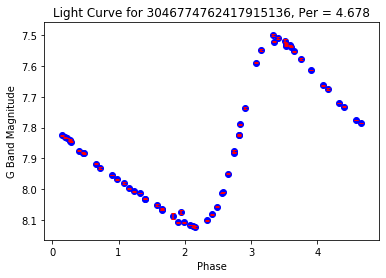

In [4]:
per = r['pf'][np.argwhere(r['source_id']==test)]
per = per[0][0]
phase = time_G % per
flux_error_G_conv = (2.5/np.log(10))*flux_error_G / flux_G
mag_error_G = flux_error_G_conv
#print(flux_error_G)
#print(flux_G)
plt.errorbar(phase, mag_G, yerr=mag_error_G, ls='None', ecolor='r', capsize=2)
plt.scatter(phase, mag_G, c='b')
plt.title('Light Curve for '+str(test)+', Per = '+ str('%.3f'%per))
plt.xlabel('Phase')
plt.ylabel('G Band Magnitude')
plt.gca().invert_yaxis()
plt.show()

## Histogram of Flux Uncertanties

In [5]:
norm = (flux_error_G - np.mean(flux_error_G))/np.std(flux_error_G)
k = np.ceil(np.sqrt(len(flux_error_G)))
#plt.hist(norm, bins=int(k))
#plt.title('Uncertanties in Flux for '+str(test))
#plt.xlabel('Flux - Mean / SD')
#plt.ylabel('Count')
#plt.show()

In [6]:
def Hist(file):
    lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3] 
    ceph_sources = np.loadtxt('vari_cepheids_long.txt', dtype=np.int64)
    for i in range(0, len(ceph_sources)):
        if ceph_sources[i] != 2964640144306230272:
            continue
        asas_ind = np.argwhere(source_id==ceph_sources[i])
        if len(asas_ind) == 0:
            continue
        #Properties of each source
        asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
        asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
        asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
        #Properties of each source seperated by band
        G_ind = np.argwhere(asas_band=='G')
        time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
        mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
        flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
        flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
        #norm = (flux_error_G - np.median(flux_error_G))/np.std(flux_error_G)
        norm = (flux_error_G - np.mean(flux_error_G))/iqr(flux_error_G)
        norm = np.abs(norm)
        print(norm)
        print(max(norm))
        print(np.argwhere(norm==max(norm)))
        print(min(norm))
        k = np.ceil(np.sqrt(len(flux_error_G)))
        plt.hist(norm, bins='auto', edgecolor='black', linewidth=1.2)
        plt.title('Uncertainties in Flux for '+str(ceph_sources[i]))
        plt.xlabel('(Flux Uncertainty - Mean)/IQR')
        plt.ylabel('Count')
        #plt.savefig('hist_'+str(ceph_sources[i])+'.png', bbox_inches='tight', dpi=300)
        plt.show()
        #print(np.mean(norm))

In [7]:
files = glob.glob('lcs_*.txt')
#for i in range(0, len(files)):
    #Hist(files[i])

In [8]:
def BigHist(ceph_sources):
    files = glob.glob('lcs_*.txt')
    norms = []
    for i in range(0, len(ceph_sources)):
        for j in range(0,len(files)):
            lcs = np.loadtxt(files[j],skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
            source_id = np.loadtxt(files[j],skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
            band = np.loadtxt(files[j],skiprows=1,delimiter=',',usecols=2, dtype=np.str)
            time = lcs[:,0]
            mag = lcs[:,1]
            flux = lcs[:,2]
            flux_error = lcs[:,3] 
            #if ceph_sources[i] != 2936194782069439872:
                #continue
            asas_ind = np.argwhere(source_id==ceph_sources[i])
            if len(asas_ind) == 0:
                continue
            #Properties of each source
            asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
            asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
            asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
            asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
            asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
            #Properties of each source seperated by band
            G_ind = np.argwhere(asas_band=='G')
            time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
            mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
            flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
            flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
            #norm = (flux_error_G - np.median(flux_error_G))/np.std(flux_error_G)
            norm = (flux_error_G - np.mean(flux_error_G))/iqr(flux_error_G)
            norm = np.abs(norm)
            #print(np.mean(norm))
            #norms.append(norm)
            norms = np.concatenate([norms, norm])
        print(str(i+1)+'/'+str(len(ceph_sources))+' Source = '+str(ceph_sources[i]))
        #print(np.shape(norms))
        #print('Norm Mean = '+str(np.mean(norms)))
    k = np.ceil(np.sqrt(len(norms)))
    plt.hist(norms, bins='auto', edgecolor='black', linewidth=1.2)
    plt.title('Uncertainties in Flux for '+str(len(ceph_sources))+' Cepheids')
    plt.xlabel('(Flux Uncertainty - Mean)/IQR')
    plt.ylabel('Count')
    #plt.savefig('bighist_auto.png', bbox_inches='tight', dpi=300)
    plt.show()

In [9]:
longlist = np.loadtxt('vari_cepheids_long.txt', dtype=np.int64)
#BigHist(longlist)

## Cepheid Table Period Error

In [10]:
per_test = r['pf'][np.argwhere(r['source_id']==3046774762417915136)]
per_test = per_test[0][0]
per_error_test = r['pf_error'][np.argwhere(r['source_id']==3046774762417915136)]
per_error_test = per_error_test[0][0]

print(per_test)
print(per_error_test)

4.6782999640058325
2.162493157106677e-05


In [11]:
for i in range(0,len(longlist)):
    per_test = r['pf'][np.argwhere(r['source_id']==longlist[i])]
    per_test = per_test[0][0]
    per_error_test = r['pf_error'][np.argwhere(r['source_id']==longlist[i])]
    per_error_test = per_error_test[0][0]
    print('Source ID '+str(longlist[i]))
    print('pf       = '+str(per_test))
    print('pf_error = '+str(per_error_test))
    print("-------")

Source ID 2964640144306230272
pf       = 6.785554638773106
pf_error = 4.610996872308052e-05
-------
Source ID 2972082493697861504
pf       = 7.822648006923116
pf_error = 0.0002476083130541003
-------
Source ID 3044483895581000192
pf       = 4.670026935723928
pf_error = 8.178016699044908e-06
-------
Source ID 3026471318138219392
pf       = 2.209805644053842
pf_error = 1.4411772284646406e-05
-------
Source ID 3046774762417915136
pf       = 4.6782999640058325
pf_error = 2.162493157106677e-05
-------
Source ID 3184429598120069120
pf       = 6.524943438916899
pf_error = 4.268088388247234e-05
-------
Source ID 3477972367780215808
pf       = 1.703571957414409
pf_error = 1.9054210929321001e-06
-------
Source ID 393953130749489152
pf       = 9.15621531835197
pf_error = 4.1092400699666954e-05
-------


## Calculating Weighted Means with 7 Degree Fit
Also: Let's try including period errors.

In [19]:
def SevDegFit(file):
    lcs = np.loadtxt(file,skiprows=1,delimiter=',',usecols=(3,4,5,6,7))
    source_id = np.loadtxt(file,skiprows=1,delimiter=',',usecols=0, dtype=np.int64)
    band = np.loadtxt(file,skiprows=1,delimiter=',',usecols=2, dtype=np.str)
    time = lcs[:,0]
    mag = lcs[:,1]
    flux = lcs[:,2]
    flux_error = lcs[:,3] 
    #flux_over_error = lcs[:,4]
    
    ceph_sources = np.loadtxt('vari_cepheids_long.txt', dtype=np.int64)
    for i in range(0, len(ceph_sources)):
        #if ceph_sources[i] != 3046774762417915136:
            #continue
        asas_ind = np.argwhere(source_id==ceph_sources[i])
        if len(asas_ind) == 0:
            continue
        per = r['pf'][np.argwhere(r['source_id']==ceph_sources[i])]
        per = per[0][0]
        if str(per) == '--':
            continue
        per_error = r['pf_error'][np.argwhere(r['source_id']==ceph_sources[i])]
        per_error = per_error[0][0]
        mag_table = r['int_average_g'][np.argwhere(r['source_id']==ceph_sources[i])]
        mag_table = mag_table[0][0]
        #Properties of each source
        asas_mag = mag[asas_ind[0][0]:asas_ind[-1][0]]
        asas_time = time[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux = flux[asas_ind[0][0]:asas_ind[-1][0]]
        asas_band = band[asas_ind[0][0]:asas_ind[-1][0]]
        asas_flux_error = flux_error[asas_ind[0][0]:asas_ind[-1][0]]
        #Properties of each source seperated by band
        G_ind = np.argwhere(asas_band=='G')
        asas_time_G = asas_time[G_ind[0][0]:G_ind[-1][0]]
        asas_mag_G = asas_mag[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_G = asas_flux[G_ind[0][0]:G_ind[-1][0]]
        asas_flux_error_G = asas_flux_error[G_ind[0][0]:G_ind[-1][0]]
        
        #Fit
        myt = asas_time_G % per
        data = asas_flux_G
        #first guesses
        guess_freq = 1
        guess_amp = 3*np.std(data)/(2**0.5)
        guess_offset = np.mean(data)
        p0=[guess_freq,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_amp,guess_offset]
        #create the function we want to fit
        def my_sin(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,offset):
            freq = 1/per
            deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
            deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
            deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
            deg4 = (np.sin(2*np.pi*4*x*freq)*amp7) + (np.cos(2*np.pi*4*x*freq)* amp8)
            deg5 = (np.sin(2*np.pi*5*x*freq)*amp9) + (np.cos(2*np.pi*5*x*freq)* amp10)
            deg6 = (np.sin(2*np.pi*6*x*freq)*amp11) + (np.cos(2*np.pi*6*x*freq)* amp12)
            deg7 = (np.sin(2*np.pi*7*x*freq)*amp13) + (np.cos(2*np.pi*7*x*freq)* amp14)
            return offset + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        def my_sin_pererr(x,freq,amp1,amp2,amp3,amp4,amp5,amp6,amp7,amp8,amp9,amp10,amp11,amp12,amp13,amp14,offset):
            freq = 1/(per+per_error)
            deg1 = (np.sin(2*np.pi*x*freq)*amp1) + (np.cos(2*np.pi*x*freq)*amp2)
            deg2 = (np.sin(2*np.pi*2*x*freq)*amp3) + (np.cos(2*np.pi*2*x*freq)* amp4)
            deg3 = (np.sin(2*np.pi*3*x*freq)*amp5) + (np.cos(2*np.pi*3*x*freq)* amp6)
            deg4 = (np.sin(2*np.pi*4*x*freq)*amp7) + (np.cos(2*np.pi*4*x*freq)* amp8)
            deg5 = (np.sin(2*np.pi*5*x*freq)*amp9) + (np.cos(2*np.pi*5*x*freq)* amp10)
            deg6 = (np.sin(2*np.pi*6*x*freq)*amp11) + (np.cos(2*np.pi*6*x*freq)* amp12)
            deg7 = (np.sin(2*np.pi*7*x*freq)*amp13) + (np.cos(2*np.pi*7*x*freq)* amp14)
            return offset + deg1 + deg2 + deg3 + deg4 + deg5 + deg6 + deg7
        #now do the fit (with uncertainties (sigma) included)
        fit = curve_fit(my_sin, myt, data, p0=p0, sigma=asas_flux_error_G, absolute_sigma=True)
        fit_pererr = curve_fit(my_sin_pererr, myt, data, p0=p0, sigma=asas_flux_error_G, absolute_sigma=True)
        
        #repeat for magnitude
        data2 = asas_mag_G
        guess_freq2 = 1
        guess_amp2 = 3*np.std(data2)/(2**0.5)
        guess_offset2 = np.mean(data2)
        p02=[guess_freq2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_amp2,guess_offset2]
        
        mag_error_G = (2.5/np.log(10))*asas_flux_error_G / asas_flux_G
        fit2 = curve_fit(my_sin, myt, data2, p0=p02, sigma=mag_error_G, absolute_sigma=True)
        fit2_pererr = curve_fit(my_sin_pererr, myt, data2, p0=p02, sigma=mag_error_G, absolute_sigma=True)
    
        C_flux = fit[0][-1]
        first_mag = asas_mag_G[0]
        first_flux = asas_flux_G[0]
        conversion = -2.5*np.log10(first_flux)-first_mag 
        
        #Phase and Fit curves
        phase = asas_time_G % per
        x = np.linspace(min(phase),max(phase),num=2**16)
        fitcurve = my_sin(x, *fit[0])
        fitcurve_pererr = my_sin_pererr(x, *fit_pererr[0])
        fitcurve2 = my_sin(x, *fit2[0])
        fitcurve2_pererr = my_sin_pererr(x, *fit2_pererr[0])
        
        ###Weighted mean: Comparing given data with fitted curve.
        #Weighted mean of Gaia flux and flux fit
        wms = []
        distances = []
        weights = []
        for  j in range(0, len(asas_flux_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            distance = asas_flux_error_G[j] - fitcurve[fit_ind]
            weight = 1/distance**2
            distances.append(distance)
            weights.append(weight)
            #wm = (asas_flux_G[j] - fitcurve[fit_ind])/asas_flux_error_G[j]**2
            wm = (asas_flux_G[j] - fitcurve)/distance**2
            wms.append(wm)
            #print('Data Value = '+str(asas_flux_G[j]))
            #print('Fit Value  = '+str(fitcurve[fit_ind]))
        #print(wms)
        
        #Weighted mean of Gaia flux and flux fit manually converted to magnitude
        wms_conv = []
        for  j in range(0, len(asas_flux_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            zp = 25.6883657251
            flux_G_conv =  zp - 2.5*np.log10(asas_flux_G)
            fitcurve_conv = zp - 2.5*np.log10(fitcurve)
            flux_error_G_conv = (2.5/np.log(10))*asas_flux_error_G / asas_flux_G
            wm_conv = (flux_G_conv[j] - fitcurve_conv[fit_ind])/flux_error_G_conv[j]**2
            wms_conv.append(wm_conv)
        
        #Weighted mean of Gaia magnitude and magnitude fit
        wms2 = []
        distances2 = []
        weights2 = []
        for j in range(0, len(asas_mag_G)):
            phase_value = phase[j]
            fit_ind = x[np.abs(x-phase_value).argmin()] #Finds nearest value in numpy array
            fit_ind = int(fit_ind)
            distance2 = asas_mag_G[j] - fitcurve2[fit_ind]
            weight2 = 1/((np.abs(distance2)+0.002)**2)
            distances2.append(distance2)
            weights2.append(weight2)
            #wm2 = (asas_mag_G[j] - fitcurve2[fit_ind])/mag_error_G[j]**2
            #wms2.append(wm2)
            #print('Data Value = '+str(asas_mag_G[j]))
            #print('Fit Value  = '+str(fitcurve2[fit_ind]))
        #print('Mean Distance = '+str(np.mean(distances2)))
        #print('Mean Weight = '+str(np.mean(weights2)))
        wf = np.average(asas_flux_G,weights=weights2)
        wf_mag = zp - 2.5*np.log10(wf) #Intensity averaged magnitude
        #print(mag_error_G)
        #print(np.mean(mag_error_G))
        
        wms_mean = np.std(wms) / np.sqrt(len(wms))
        wms_conv_mean = np.std(wms_conv) / np.sqrt(len(wms_conv))
        wms2_mean = np.std(wms2) / np.sqrt(len(wms2))
        
        #recreate the fitted curve using the optimized parameters
        #Plotting flux
        plt.plot(x, fitcurve, c='r')
        plt.plot(x, fitcurve_pererr, c='k', ls='--')
        plt.errorbar(phase, asas_flux_G, yerr=asas_flux_error_G, ls='None', ecolor='k', capsize=2)
        plt.scatter(phase, asas_flux_G, c='g')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('G Band Flux')
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_flux_sigma.png', bbox_inches='tight', dpi=300)
        plt.show()
        #Plotting mag
        plt.errorbar(phase, asas_mag_G, yerr=mag_error_G, ls='None', ecolor='green', capsize=2)
        plt.scatter(phase, asas_mag_G, c='b')
        plt.plot(x, fitcurve2, c='r')
        plt.plot(x, fitcurve2_pererr, c='k', ls='--')
        plt.title('Light Curve for ' + str(ceph_sources[i]) +', Per = '+ str('%.3f'%per))
        plt.xlabel('Phase')
        plt.ylabel('Vega Magnitude')
        plt.gca().invert_yaxis()
        #plt.savefig('LCfit_'+str(ceph_sources[i])+'_deg7_mag.png', bbox_inches='tight', dpi=300)
        plt.show()
        
        #Stuff to print
        av_mag_mag = np.mean(fitcurve2)
        av_mag_flux = -2.5*np.log10((np.mean(fitcurve)))
        first_mag_flux = -2.5*np.log10((np.mean(first_flux)))
        C_flux_conv = -2.5*np.log10((C_flux))
        C_calc = C_flux_conv - conversion
        
        #print('C_flux = ' + str(fit[0][-1]))
        #print('Conversion = '+str(conversion))
        
        #print('STD Flux Fit = '+str(std))
        #print('WF     = '+str(wf))
        
        #std = np.std(fitcurve)
        med = np.median(zp - 2.5*np.log10(asas_flux_G))
        mea = zp - 2.5*np.log10(np.mean(asas_flux_G))
        #std2 = np.std(fitcurve2)
        med2 = np.median(asas_mag_G)
        mea2 = np.mean(asas_mag_G)
       
        #Gisella int av mag
        gis_flux = 10**((zp - fitcurve2)/2.5)
        gis_flux_mean = np.mean(gis_flux)
        gis_mag = zp - 2.5*np.log10(gis_flux_mean)
        
        #print(std2)
        print('C_mag            = '+str(fit2[0][-1]))
        print('C_flux           = '+str(C_calc))
        print('WF_mag           = '+str(wf_mag))
        print('Median_flux      = '+str(med))
        print('Mean_flux        = '+str(mea))
        print('Median_mag       = '+str(med2))
        print('Mean_mag         = '+str(mea2))
        print('int_avg_mag      = '+str(mag_table))
        print('Gisella          = '+str(gis_mag))
        #print('Weighted Mean Flux = '+str(wms_conv_mean))
        #print('Weighted Mean Mag  = '+str(wms2_mean))
        #print('WMF / WMM = '+str(wms_conv_mean / wms2_mean))

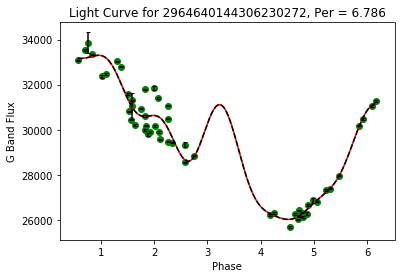

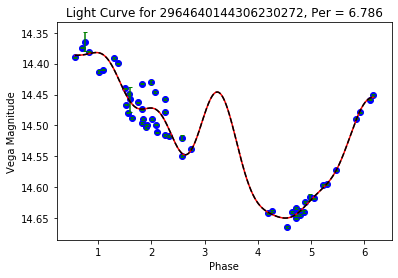

C_mag            = 14.503338609089504
C_flux           = 14.50015130969205
WF_mag           = 14.392021520409664
Median_flux      = 14.489458063806893
Mean_flux        = 14.50873560143645
Median_mag       = 14.48945806382644
Mean_mag         = 14.512184664565916
int_avg_mag      = 14.508817016968013
Gisella          = 14.515224802898143


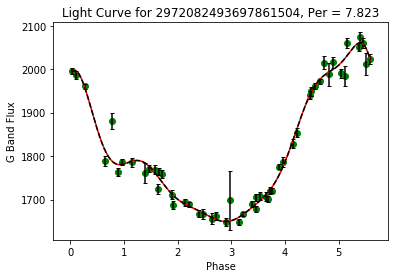

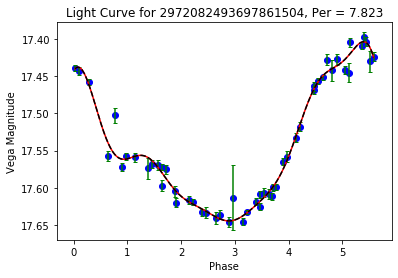

C_mag            = 17.621109957533545
C_flux           = 17.65133424868535
WF_mag           = 17.441225869921084
Median_flux      = 17.567615706901385
Mean_flux        = 17.536975928771653
Median_mag       = 17.567615706920932
Mean_mag         = 17.540094032945536
int_avg_mag      = 17.505344124281315
Gisella          = 17.542293050219573


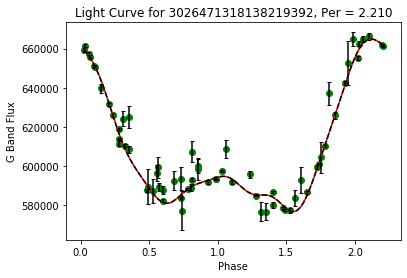

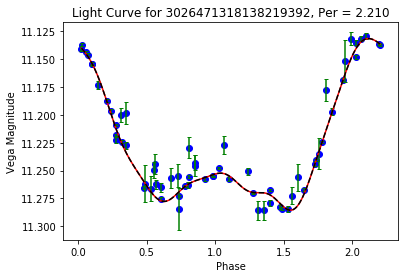

C_mag            = 11.230635520322709
C_flux           = 11.229491460023034
WF_mag           = 11.141105355931979
Median_flux      = 11.243808845023292
Mean_flux        = 11.22218114798372
Median_mag       = 11.243808845042839
Mean_mag         = 11.22336360671112
int_avg_mag      = 11.23114536272185
Gisella          = 11.230848286775625


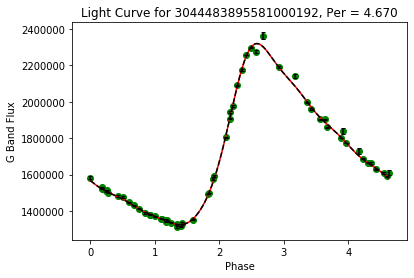

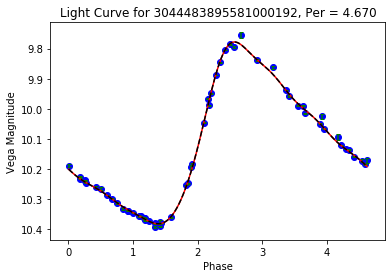

C_mag            = 10.112865817010668
C_flux           = 10.095233517606426
WF_mag           = 10.196110660845315
Median_flux      = 10.188966849381146
Mean_flux        = 10.139702898209856
Median_mag       = 10.188966849400693
Mean_mag         = 10.156286553143016
int_avg_mag      = 10.08493116189138
Gisella          = 10.094335756896491


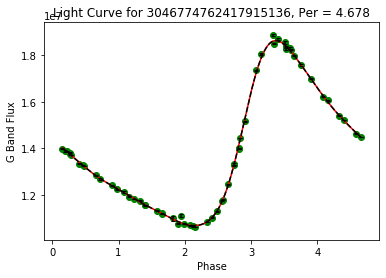

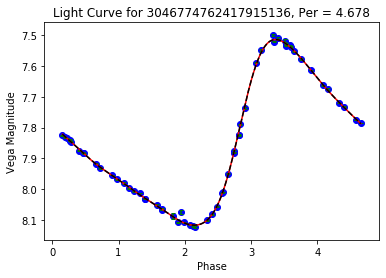

C_mag            = 7.846521226358615
C_flux           = 7.828639571028802
WF_mag           = 7.8252081823994075
Median_flux      = 7.875504437404148
Mean_flux        = 7.830667057715594
Median_mag       = 7.875504437423695
Mean_mag         = 7.849281661719563
int_avg_mag      = 7.830550402788656
Gisella          = 7.829513279073687


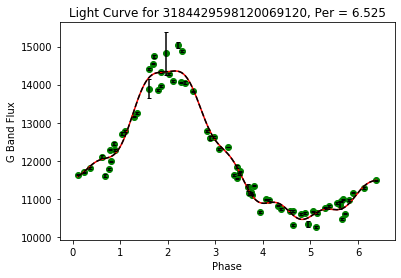

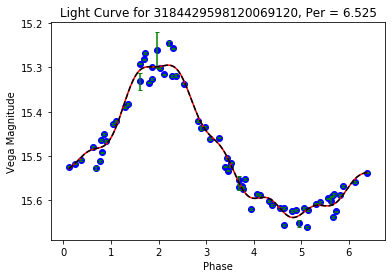

C_mag            = 15.492939975086545
C_flux           = 15.487354609349818
WF_mag           = 15.526830594988127
Median_flux      = 15.52342777643954
Mean_flux        = 15.485695428528661
Median_mag       = 15.523427776459087
Mean_mag         = 15.49255662363033
int_avg_mag      = 15.487932490847571
Gisella          = 15.485156903330864


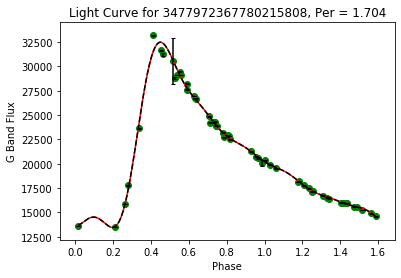

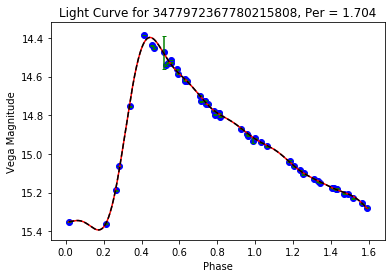

C_mag            = 14.97996092808822
C_flux           = 14.936054019350697
WF_mag           = 15.351240073691706
Median_flux      = 14.901714825655102
Mean_flux        = 14.85724385019217
Median_mag       = 14.901714825674649
Mean_mag         = 14.890442544961813
int_avg_mag      = 14.949039542984625
Gisella          = 14.911271059130712


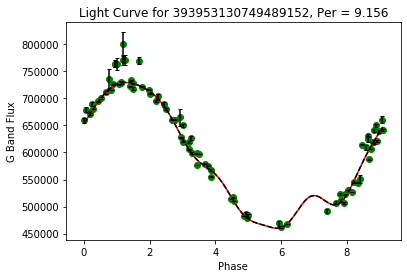

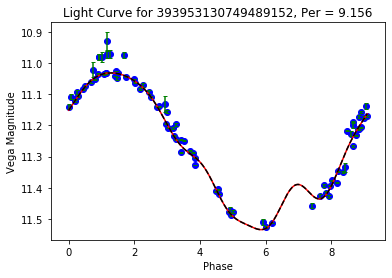

C_mag            = 11.28407042238779
C_flux           = 11.271289959464363
WF_mag           = 11.150753990268013
Median_flux      = 11.188834682239797
Mean_flux        = 11.19047193264827
Median_mag       = 11.188834682259344
Mean_mag         = 11.201657705887971
int_avg_mag      = 11.28036520478319
Gisella          = 11.271722711897818


In [20]:
files = glob.glob('lcs_*.txt')
for i in range(0, len(files)):
    SevDegFit(files[i])

In [14]:
apublic double[] computeIntAverage(LcFitParameters lcFitParameters1, int numberOfPointsToBeUsed) 
                                      throws DerivedTimeSeriesCreationException, ProcessingFailedException {
        double intAverage1 = 0.0;
        double devStandard = 0.0;
        double averageMagError = 0.0;
        final double[] result1 = new double[2];
        double[] magModel = null;

        final double[] mag1 = modelfilled(lcFitParameters1, numberOfPointsToBeUsed);
        magModel = mag1;
        final double[] intensities = new double[magModel.length];
        for (int i = 0; i < magModel.length; i++) {
            intensities[i] = Math.pow(10, -magModel[i] / 2.5);
        }
        // from Vincenzo formula.
        final double zeroIntensity = (intensities[0] + intensities[intensities.length - 1]) / 2;
        for (int i = 1; i < intensities.length - 2; i++) {
            intAverage1 += intensities[i];
        }
        intAverage1 += zeroIntensity;
        intAverage1 = intAverage1 / (magModel.length - 1);
        
        final double averageMag = -2.5 * Math.log10(intAverage1);
        for (int i = 0; i < magModel.length; i++) {
            devStandard += Math.pow((intensities[i] - intAverage1), 2);
        }

        devStandard = Math.sqrt(devStandard / (magModel.length - 1));

        averageMagError = 2.5  Math.log(10) / intAverage1  devStandard;

        result1[0] = averageMag;
        result1[1] = averageMagError;

        if(result1[0] == Double.NEGATIVE_INFINITY || result1[0] == Double.POSITIVE_INFINITY){ /// This if was added to solve a Jira C7SO-272
            result1[0] = Double.NaN;
            result1[1] = Double.NaN;    
        }
        
        return result1;
    }re back

SyntaxError: invalid syntax (<ipython-input-14-8df0fe97f5aa>, line 1)

In [ ]:
#Pseudocode: (flux_error_G[phase] - fitcurve[phase])/sigma**2